In [1]:
import cv2
import yaml
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from ultralytics import YOLO, YOLOWorld

In [2]:
import utils

import importlib
importlib.reload(utils)

<module 'utils' from '/home/tom/Documents/UNT/csce6260/projects/kitti-experiments/rgb/utils.py'>

## Load data

In [3]:
base = Path.home() / "kitti"
train_dir = base / "training"
train_img_dir = train_dir / "image_2"
kitti_images_train = sorted(train_img_dir.glob("*.png"))
train_labels_dir = train_dir / "label_2"
kitti_train_labels = sorted(train_labels_dir.glob("*.txt"))

## Open World Detection Model Initialization

In [4]:
model = YOLOWorld("yolov8x-worldv2.pt")
target_classes = ["car", "van", "truck", "pedestrian", "person_sitting", "cyclist", "tram"]  
class_map = {idx: class_name for idx, class_name in enumerate(target_classes)}
model.set_classes(target_classes)
print(target_classes)

['car', 'van', 'truck', 'pedestrian', 'person_sitting', 'cyclist', 'tram']


Ground-truth objects and their metadata:
[{'type': 'Pedestrian', 'truncated': 0.0, 'occluded': 0, 'alpha': -0.2, 'bbox_2d': (712.4, 143.0, 810.73, 307.92), 'dimensions': (1.89, 0.48, 1.2), 'centroid': (1.84, 1.47, 8.41), 'rotation_y': 0.01}]
Sample Image Path: /home/tom/kitti/training/image_2/000000.png



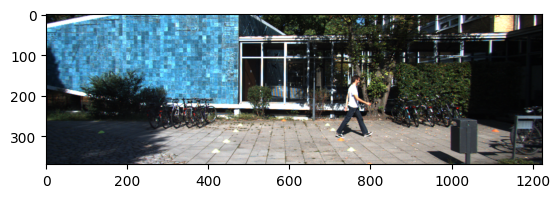

In [5]:
analysis_file_index = 0

sample_label = utils.parse_label_file(kitti_train_labels[analysis_file_index])
print("Ground-truth objects and their metadata:")
print(sample_label)

sample_image_path = kitti_images_train[analysis_file_index]
print("Sample Image Path: {}\n".format(sample_image_path))
sample_image = cv2.imread(sample_image_path)
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image_rgb)


0: 224x640 1 person_sitting, 516.3ms
Speed: 1.9ms preprocess, 516.3ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)
[{'bounding_box': [712.96923828125, 151.35885620117188, 805.6099243164062, 304.69000244140625], 'object_name': 'person_sitting', 'confidence': 0.6992638111114502}]


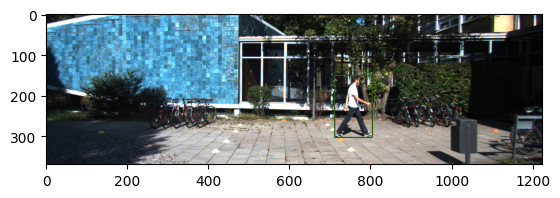

In [6]:
det_boxes, det_class_ids, det_scores = utils.perform_detection_and_nms(model, sample_image, det_conf=0.35, nms_threshold=0.25)

if det_boxes.ndim == 1:
    det_boxes = np.reshape(det_boxes, (1,4))
    det_class_ids = [det_class_ids]
    det_scores = [det_scores]

pred_detections = []
for box, class_id, score in zip(det_boxes, det_class_ids, det_scores):
    class_name = class_map[class_id]
    pred_detections.append({
        "bounding_box": box.tolist(),
        "object_name": class_name,
        "confidence": float(score)
    })

print(pred_detections)

predicted_image = utils.draw_detection_output(sample_image_rgb, pred_detections)
cv2.imwrite("predicted_image.png", predicted_image[:,:,::-1])
plt.imshow(predicted_image);

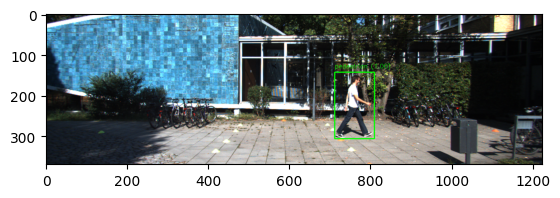

In [7]:
def get_gt_detections(gt_labels):
    gt_detections = []
    for label in gt_labels:
        class_name = label["type"].lower()
        if class_name != "dontcare":
            x_min, y_min, x_max, y_max = label["bbox_2d"]
            gt_detections.append({
                "bounding_box": [x_min, y_min, x_max, y_max],
                "object_name": class_name.lower(),
                "confidence": float(1.0)
            })
    return gt_detections

gt_detections = get_gt_detections(sample_label)
gt_image = utils.draw_detection_output(sample_image_rgb, gt_detections, color_rgb=(0, 255, 0))
cv2.imwrite("gt_image.png", gt_image[:,:,::-1])
plt.imshow(gt_image);

In [8]:
print("# predicted boxes: {}".format(len(pred_detections)))
print("# G.T. boxes: {}".format(len(gt_detections)))
gt_detections = [obj for obj in gt_detections if obj.get("object_name") != "dontcare"]
results = utils.evaluate_detections(pred_detections, gt_detections, iou_threshold=0.40)
precision, recall = utils.calculate_precision_recall(results)
print(f"{{'TP': {results['TP']}, 'FP': {results['FP']}, 'FN': {results['FN']}}}")
print(f"Precision: {precision}, Recall: {recall}")

# predicted boxes: 1
# G.T. boxes: 1
{'TP': 0, 'FP': 1, 'FN': 1}
Precision: 0.0, Recall: 0.0


## Evaluating Fine-Tuned YOLOv8 on a Sample KITTI Image

In [9]:
fine_tuned_model = YOLO("yolo_results/weights_best.pt")

In [10]:
with open(r"/home/tom/datasets/kitti/data.yaml") as stream:
    try:
        tuned_model_class_names = yaml.safe_load(stream)['names']
        print(tuned_model_class_names)
    except yaml.YAMLError as exc:
        print(exc)

{0: 'Car', 1: 'Pedestrian', 2: 'Cyclist'}


In [11]:
sample_image_path = "/home/tom/datasets/kitti/images/val/000780.png"
sample_image = cv2.imread(sample_image_path)
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

sample_label_path = "/home/tom/kitti/training/label_2/000780.txt"
sample_label = utils.parse_label_file(sample_label_path)
gt_detections = get_gt_detections(sample_label)

In [12]:
tuned_model_det_boxes, tuned_model_det_class_ids, tuned_model_det_scores = utils.perform_detection_and_nms(
    fine_tuned_model, sample_image, det_conf= 0.10, nms_threshold= 0.50)


0: 224x640 10 Cars, 5 Pedestrians, 1 Cyclist, 198.5ms
Speed: 1.5ms preprocess, 198.5ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)


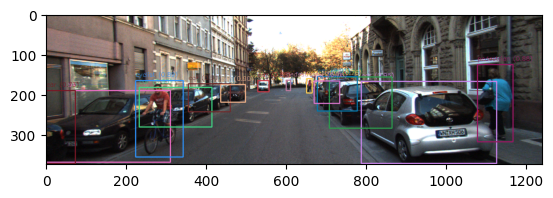

In [13]:
tuned_model_pred_detections = []
for box, class_id, score in zip(tuned_model_det_boxes, tuned_model_det_class_ids, tuned_model_det_scores):
    class_name = tuned_model_class_names[class_id].lower()
    tuned_model_pred_detections.append({
        "bounding_box": box.tolist(),
        "object_name": class_name,
        "confidence": float(score)
    })

tuned_model_pred_image = utils.draw_detection_output(sample_image_rgb, tuned_model_pred_detections)
cv2.imwrite('tuned_model_pred_image.png', tuned_model_pred_image[:,:,::-1])
plt.imshow(tuned_model_pred_image);

In [14]:
print("# predicted boxes: {}".format(len(tuned_model_pred_detections)))
print("# G.T. boxes: {}".format(len(gt_detections)))
gt_detections = [obj for obj in gt_detections if obj.get("object_name") != "dontcare"]
results = utils.evaluate_detections(tuned_model_pred_detections, gt_detections, iou_threshold=0.40)
precision, recall = utils.calculate_precision_recall(results)
print(f"{{'TP': {results['TP']}, 'FP': {results['FP']}, 'FN': {results['FN']}}}")
print(f"Precision: {precision}, Recall: {recall}")

# predicted boxes: 14
# G.T. boxes: 15
{'TP': 14, 'FP': 0, 'FN': 1}
Precision: 1.0, Recall: 0.9333333333333333
